## Incorporate thresholded zero-crossings into the model

In [12]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import find_peaks

np.random.seed(1337) # for reproducibility

In [46]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings

def load_thres_product(dir_path, time_range):
    #load time axis
    time_axis = load_time_label(dir_path, time_range = (-200,0), window = 25000, step = 10)
    
    #Load data
    product_data = np.load(dir_path+"cross-product.npy")
    
    #return the data in time_range
    selection_index = (time_axis > time_range[0]) & (time_axis < time_range[1]) 
    %reset -f in
    
    return product_data[selection_index][:, np.newaxis]


def generate_data(dir_path, time_range, window = 2000, step = 10):
    
    #Selection index due to using different window
    #selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step) ##!!!!!! CAREFUL
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)
    moving_thres_crossings = load_thres_product(dir_path, time_range = (time_label.min() - 1e-4, time_label.max()))
    
    
    all_data = np.concatenate((moving_mean, moving_sd, moving_thres_crossings**2), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    plt.figure(figsize=(20,2))
    plt.plot(all_data[:,12])
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=13))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(13,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')


    return model

def train(current_weights, X, time_axis, time_range):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = np.copy(X[start_index:end_index])
    time_train = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Scaler initiation
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    X_train[:,12] = (1.1)**(X_train[:,12]) #More importance in product of zero-crossings
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=30, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    #Plot the reconstruction loss
    plt.figure(figsize=(20,2))
    plt.plot(time_train, loss)
    plt.title("TRAINING reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Take the mean of the log loss and update the mean threshold
    current_median = np.median(np.log10(loss))
    
    print("Finished training, median of the log(loss) is: ", current_median)
    
    return new_weights, current_median, scaler

def trigger(current_weights, X, time_axis, time_range, prev_median, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this median for triggering:", prev_median)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    time_test = time_axis[start_index:end_index]
    X_test = np.copy(X[start_index:end_index])
    
    X_test = scaler.transform(X_test) #Scale the current data
    X_test[:,12] = (1.1)**(X_test[:,12]) #Put more importance on the product of zero crossings
    
    #Create model
    model = create_model()
    model.set_weights(current_weights)
        
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(time_test, test_loss)
    plt.title("Reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Quantify how much each data point is far away from the distribution
    log_test_loss = np.log10(test_loss) - prev_median
    
    #Find the trigger time
    trigger_index = np.argmax(log_test_loss > 3.3)
    
    if  trigger_index != 0:
        #Plot the triggered time
        plt.figure(figsize=(20,2))
        plt.plot(time_test, log_test_loss, color = "firebrick")
        plt.title("Log reconstruction loss on {}".format(time_range))
        plt.xlabel("Time [s]")
        
        #Trigger time
        plt.vlines(time_test[trigger_index], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed", label = "Trigger time")
        plt.legend(loc = "upper left")
        
        
        ### Find trigger times
        peaks, _ = find_peaks(log_test_loss, height=3.3, distance = 5000)
        print("Other trigger time: ", time_test[peaks])
        print("Their log loss values are: ", log_test_loss[peaks])
        
        for i in range(len(peaks)):
            plt.vlines(time_test[peaks[i]], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed")
            
        plt.show()
        
        return list(time_test[peaks])
    
    else:
        return None
    

def simulation(dir_path, section_size, time_range):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_median = None
    updated_median = None
    
    #Keeping track of scaler after training
    past_scaler = None
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Keeping log of all the trigger time
    trigger_log = []
    
    #Sequentially go through the data
    for i in range(num_section):
        
        print("Entering sections: ", (-section_size*(num_section - i), -section_size*(num_section - i - 1)))
        print("-------->")
        
        if i == 0:
            continue
        elif i == 1:
            #Train on the first segment
            time_range = (None, -section_size*(num_section - i))
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, time_range)
        else:
            
            #Set previous distrubution to the newly trained disttribution
            prev_median = updated_median
            current_scaler = new_scaler
            current_weights = new_weights
            
            #Selecting appropriate time range for training and triggering
            train_time_range = (-section_size*(num_section - i + 1), -section_size*(num_section - i))
            trigger_time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
            
            #Train and predict simutaneously
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, train_time_range)
            trigger_time = trigger(current_weights, X, time_axis, trigger_time_range, prev_median, current_scaler)
            
            if trigger_time is not None:
                print("Triggered at: ", trigger_time)
                trigger_log.extend(trigger_time)
        
        print("<--------")
        
    print("Finished simulation, all the triggered times are: ", trigger_log)

In [ ]:
## Threshold 3.0; constant 1.1, power of 3

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (1997500, 13)
Flushing input history
Number of sections: 20
Entering sections:  (-200, -190)
-------->
Entering sections:  (-190, -180)
-------->
Training for section:  (None, -190)


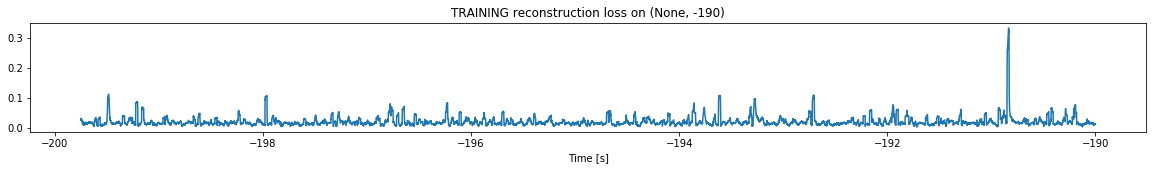

Finished training, median of the log(loss) is:  -1.7829758133216433
<--------
Entering sections:  (-180, -170)
-------->
Training for section:  (-190, -180)


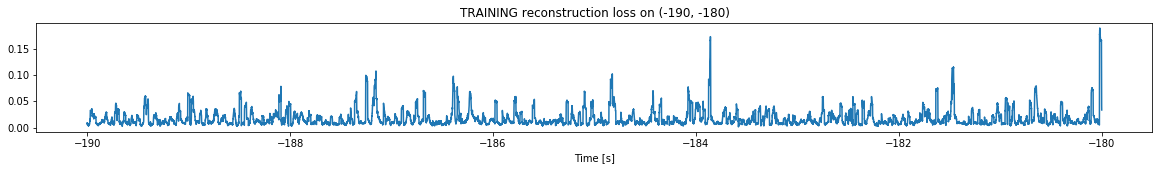

Finished training, median of the log(loss) is:  -1.9064654484812655
Triggering for section:  (-180, -170)
Using this median for triggering: -1.7829758133216433


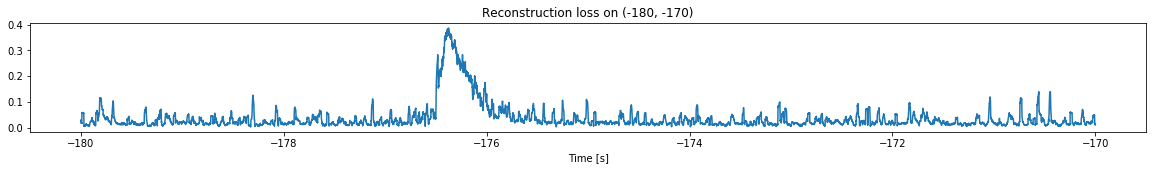

<--------
Entering sections:  (-170, -160)
-------->
Training for section:  (-180, -170)


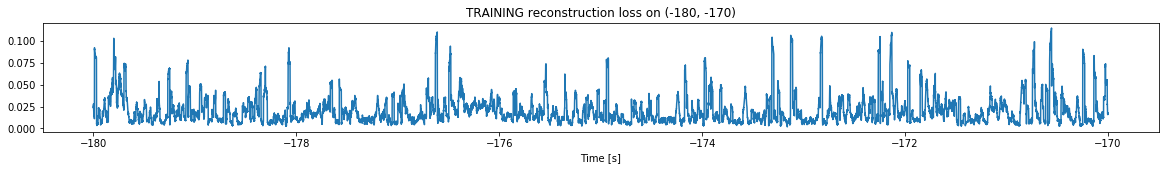

Finished training, median of the log(loss) is:  -1.789623621043198
Triggering for section:  (-170, -160)
Using this median for triggering: -1.9064654484812655


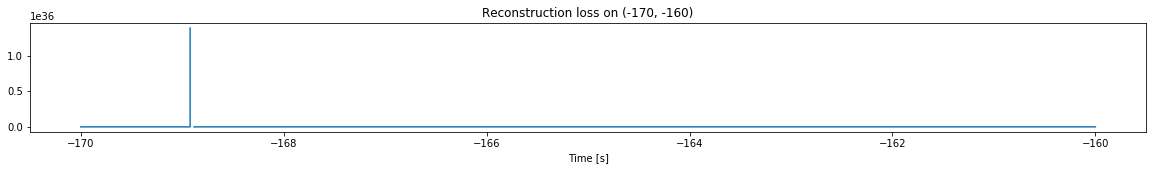

/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in greater


Other trigger time:  [-168.82687 -166.4916 ]
Their log loss values are:  [17.62279943  3.03270333]


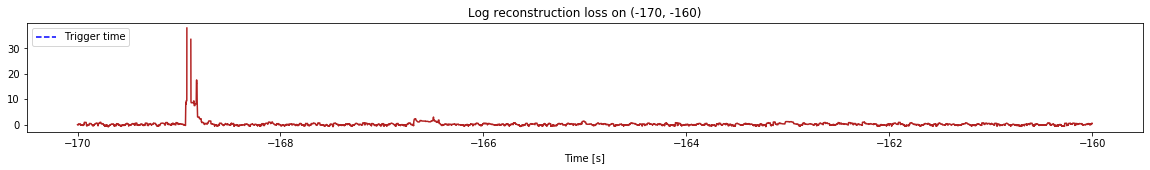

Triggered at:  [-168.82687, -166.4916]
<--------
Entering sections:  (-160, -150)
-------->
Training for section:  (-170, -160)


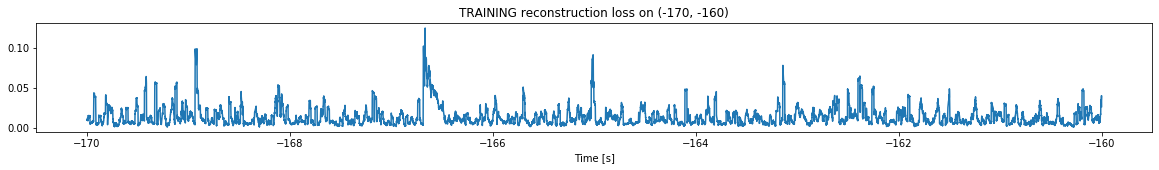

Finished training, median of the log(loss) is:  -1.9847522814211758
Triggering for section:  (-160, -150)
Using this median for triggering: -1.789623621043198


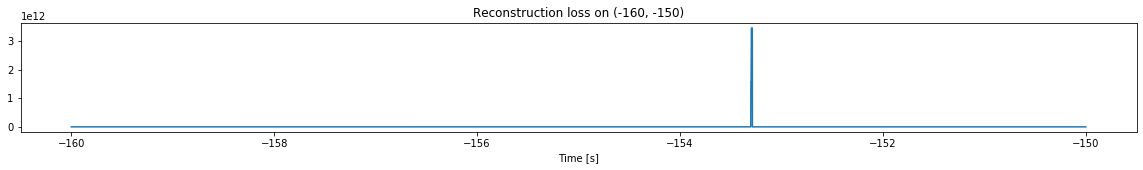

Other trigger time:  [-153.28778]
Their log loss values are:  [14.3284563]


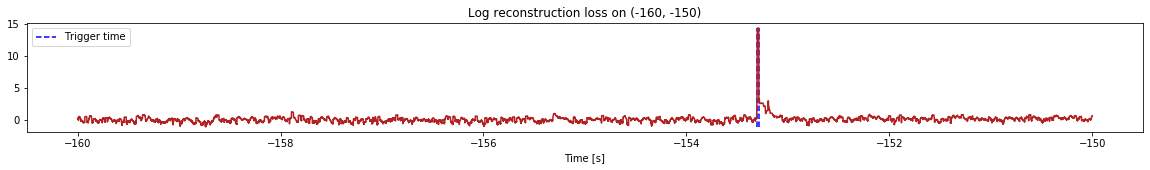

Triggered at:  [-153.28778]
<--------
Entering sections:  (-150, -140)
-------->
Training for section:  (-160, -150)


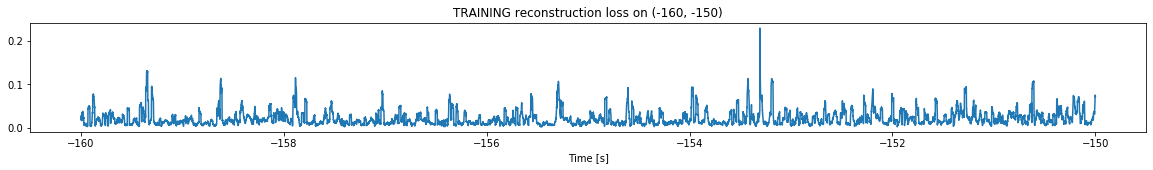

Finished training, median of the log(loss) is:  -1.7964868758990438
Triggering for section:  (-150, -140)
Using this median for triggering: -1.9847522814211758


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: overflow encountered in power


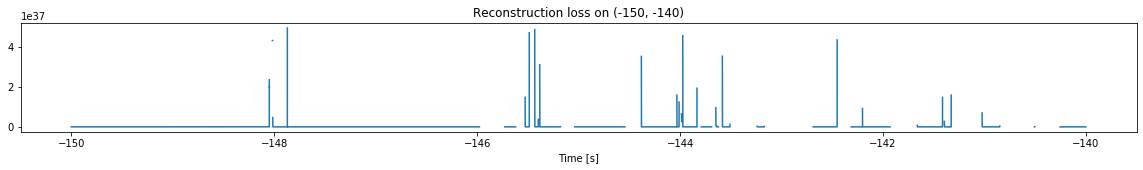

/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in greater


Other trigger time:  [-148.00539 -146.60258 -145.40349 -144.36908 -143.63148 -141.99028
 -141.48988 -140.85748]
Their log loss values are:  [33.61129932 16.31965748 32.14535247 34.58747623 28.18997793  4.71366379
 24.60397214 23.91199149]


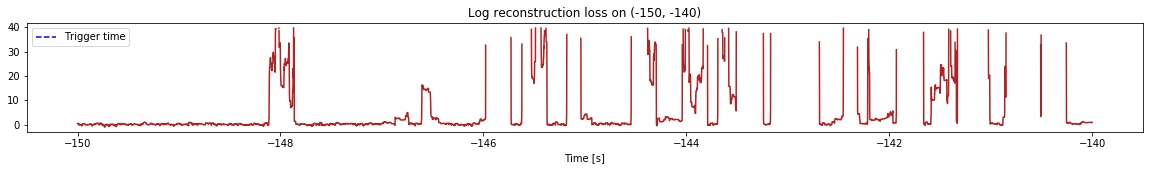

Triggered at:  [-148.00539, -146.60258, -145.40349, -144.36908, -143.63148, -141.99028, -141.48988, -140.85748]
<--------
Entering sections:  (-140, -130)
-------->
Training for section:  (-150, -140)


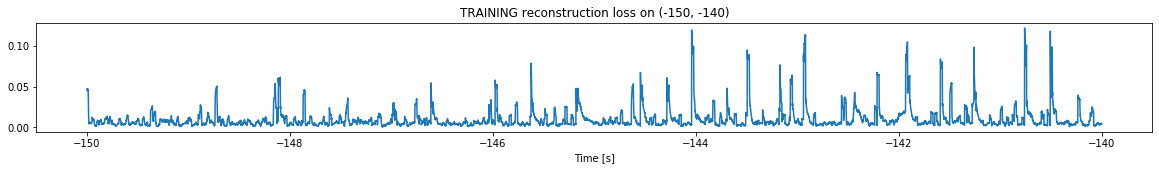

Finished training, median of the log(loss) is:  -2.1929474574291845
Triggering for section:  (-140, -130)
Using this median for triggering: -1.7964868758990438


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: overflow encountered in power


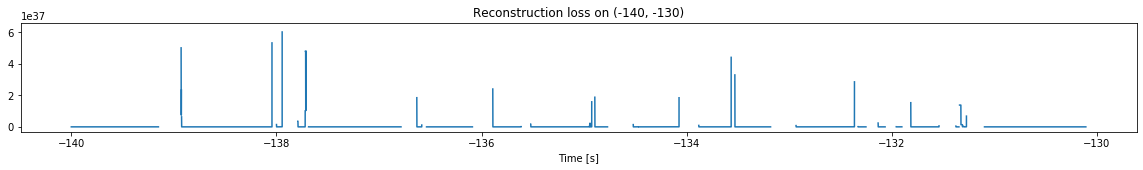

/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in greater


Other trigger time:  [-139.86438 -138.91528 -137.7788  -136.62788 -136.12749 -135.50468
 -134.94289 -133.86868 -132.38109 -131.3039  -130.76549]
Their log loss values are:  [27.04159431 22.49418704 35.61691876 12.29565876 10.38199333 33.18959104
 38.16301847 12.22170743 34.57577707 37.28818649 23.54203324]


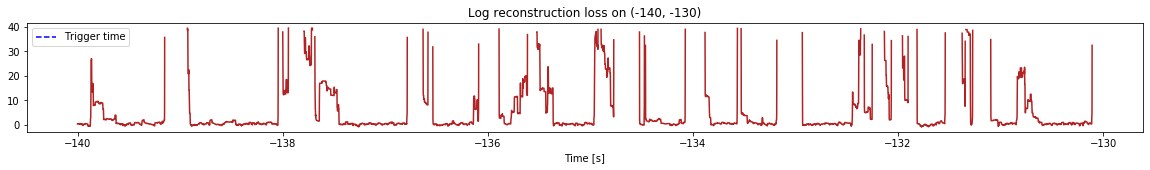

Triggered at:  [-139.86438, -138.91528, -137.7788, -136.62788, -136.12749, -135.50468, -134.94289, -133.86868, -132.38109, -131.3039, -130.76549]
<--------
Entering sections:  (-130, -120)
-------->
Training for section:  (-140, -130)


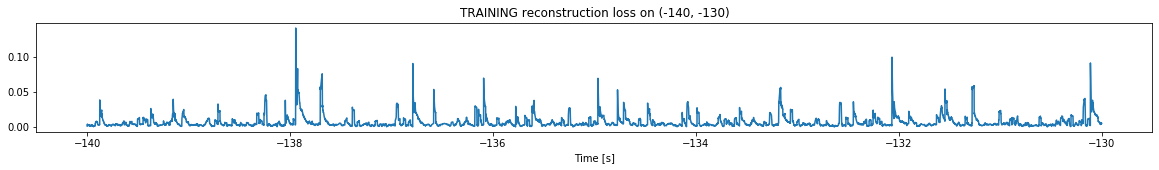

Finished training, median of the log(loss) is:  -2.3548134782662675
Triggering for section:  (-130, -120)
Using this median for triggering: -2.1929474574291845


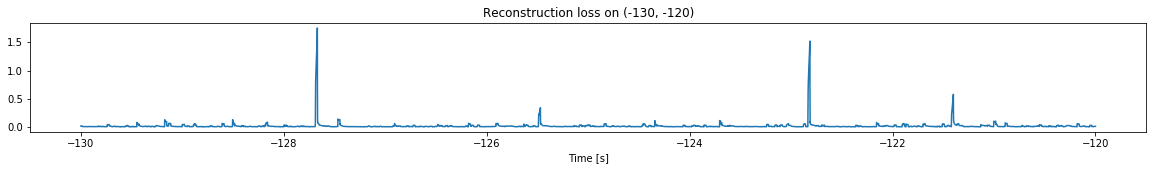

<--------
Entering sections:  (-120, -110)
-------->
Training for section:  (-130, -120)


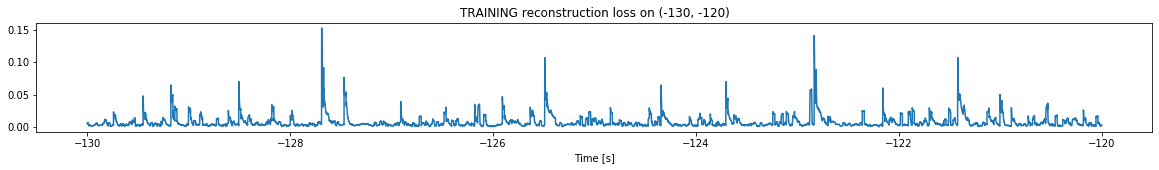

Finished training, median of the log(loss) is:  -2.290607220064224
Triggering for section:  (-120, -110)
Using this median for triggering: -2.3548134782662675


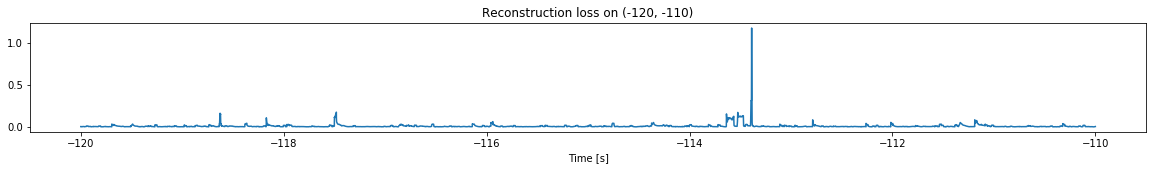

<--------
Entering sections:  (-110, -100)
-------->
Training for section:  (-120, -110)


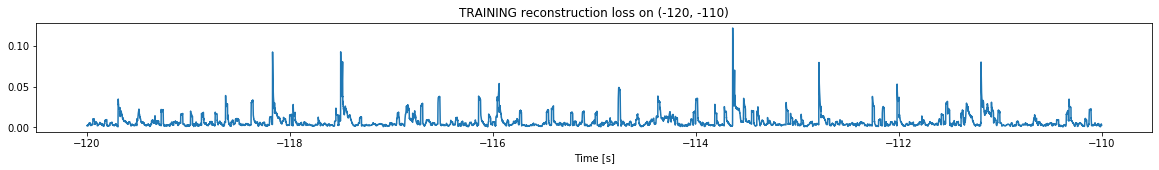

Finished training, median of the log(loss) is:  -2.3538078975731795
Triggering for section:  (-110, -100)
Using this median for triggering: -2.290607220064224


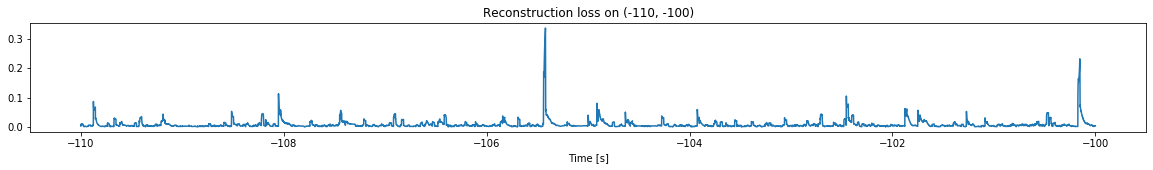

<--------
Entering sections:  (-100, -90)
-------->
Training for section:  (-110, -100)


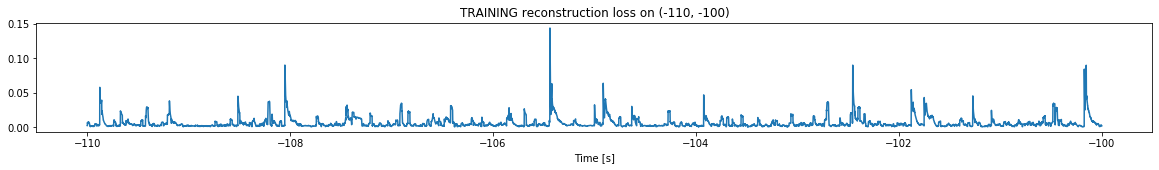

Finished training, median of the log(loss) is:  -2.4017422550031684
Triggering for section:  (-100, -90)
Using this median for triggering: -2.3538078975731795


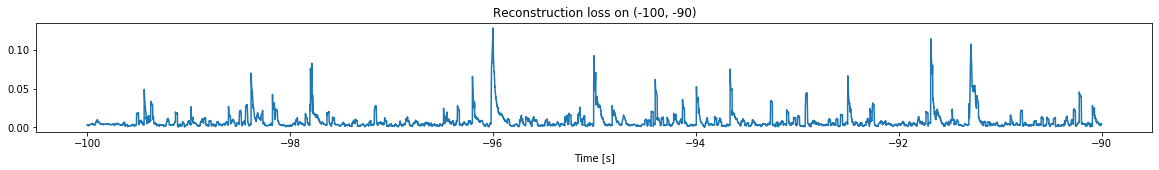

<--------
Entering sections:  (-90, -80)
-------->
Training for section:  (-100, -90)


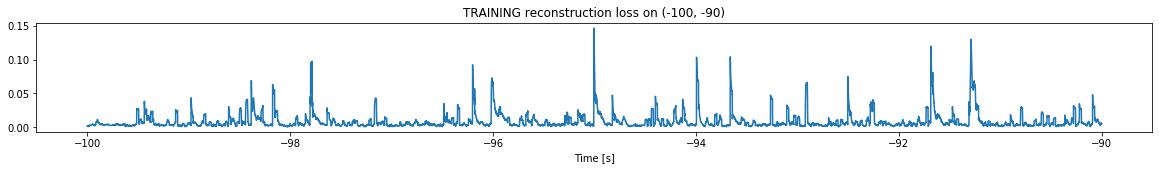

Finished training, median of the log(loss) is:  -2.291274331043681
Triggering for section:  (-90, -80)
Using this median for triggering: -2.4017422550031684


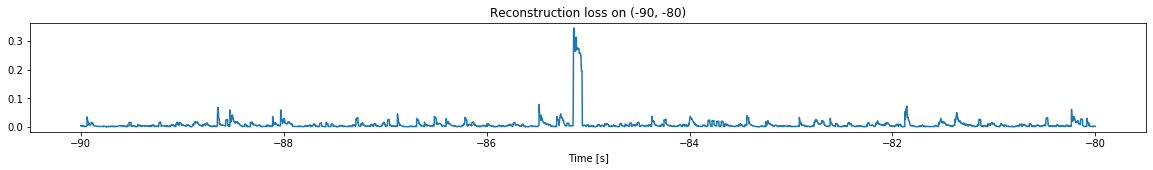

<--------
Entering sections:  (-80, -70)
-------->
Training for section:  (-90, -80)


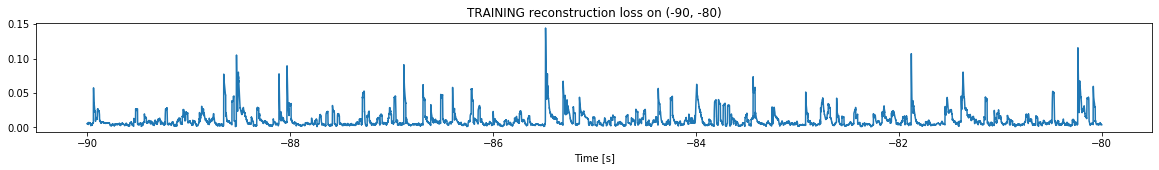

Finished training, median of the log(loss) is:  -2.169856783740793
Triggering for section:  (-80, -70)
Using this median for triggering: -2.291274331043681


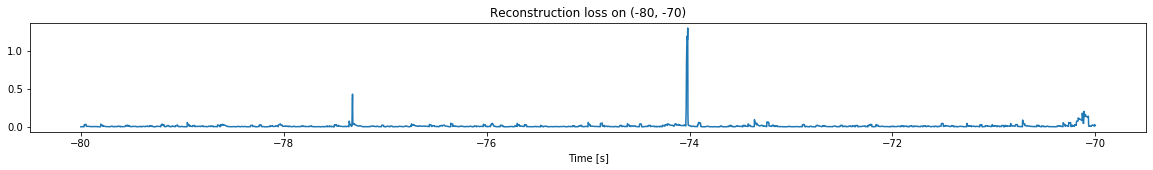

<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


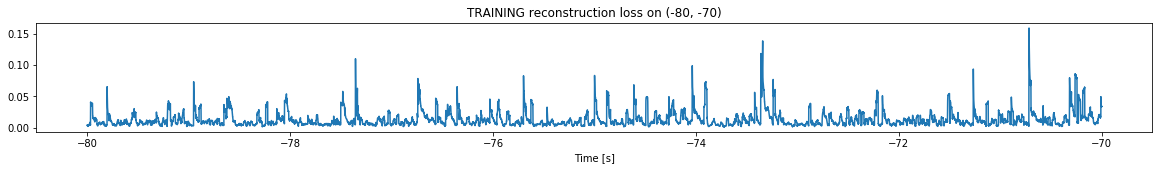

Finished training, median of the log(loss) is:  -2.022485347582383
Triggering for section:  (-70, -60)
Using this median for triggering: -2.169856783740793


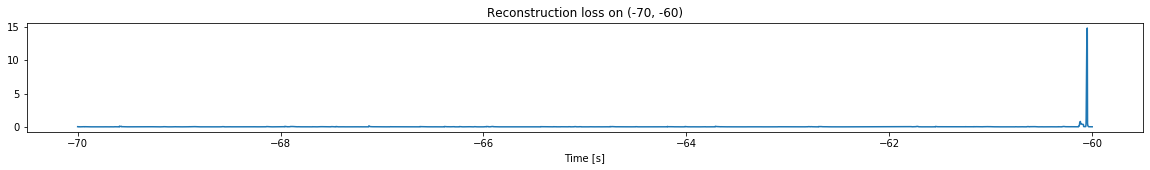

Other trigger time:  [-60.04899]
Their log loss values are:  [3.34115369]


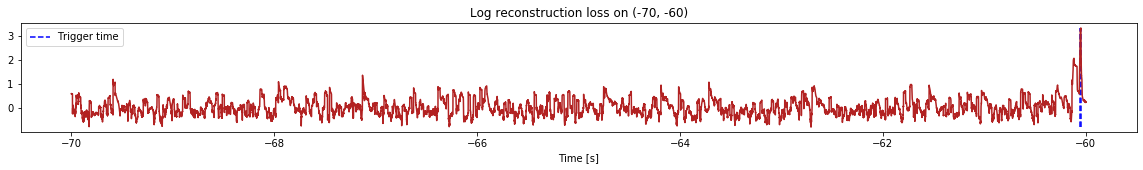

Triggered at:  [-60.04899]
<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


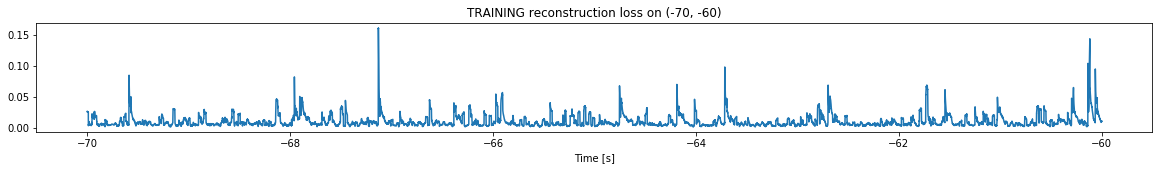

Finished training, median of the log(loss) is:  -2.168830486965404
Triggering for section:  (-60, -50)
Using this median for triggering: -2.022485347582383


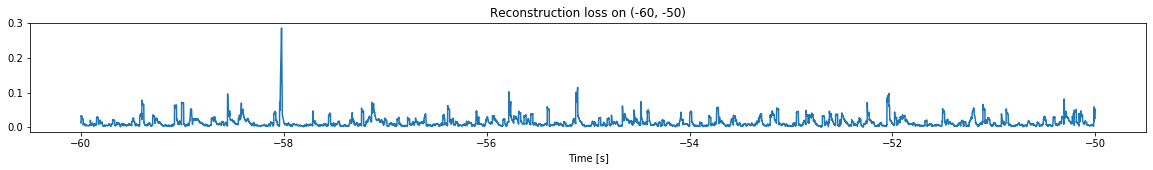

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


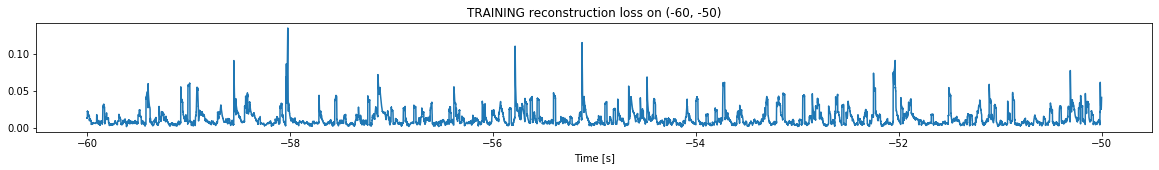

Finished training, median of the log(loss) is:  -2.0614323488150283
Triggering for section:  (-50, -40)
Using this median for triggering: -2.168830486965404


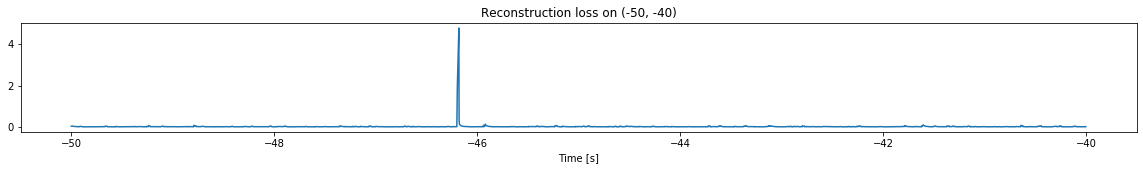

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


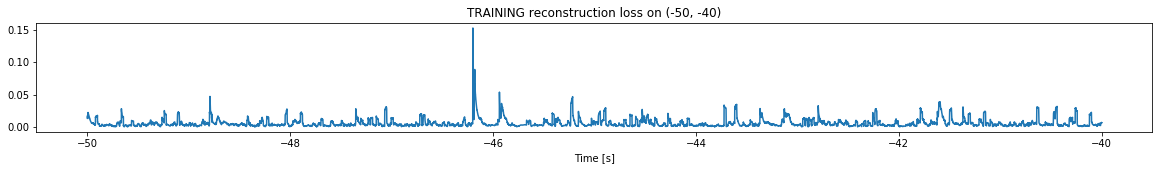

Finished training, median of the log(loss) is:  -2.3622399756615415
Triggering for section:  (-40, -30)
Using this median for triggering: -2.0614323488150283


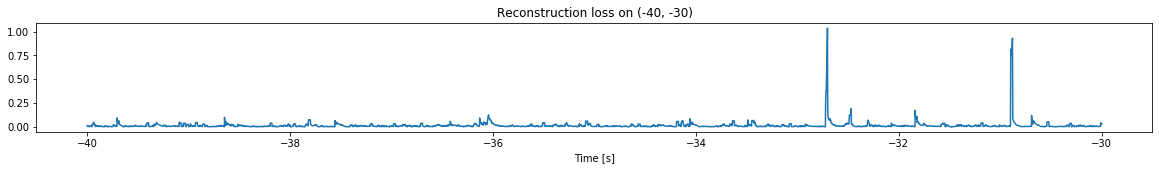

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


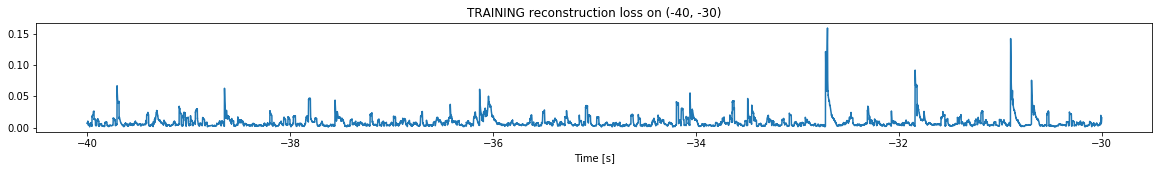

Finished training, median of the log(loss) is:  -2.247555854777251
Triggering for section:  (-30, -20)
Using this median for triggering: -2.3622399756615415


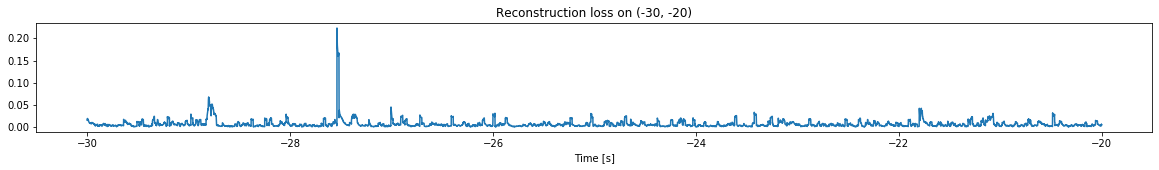

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


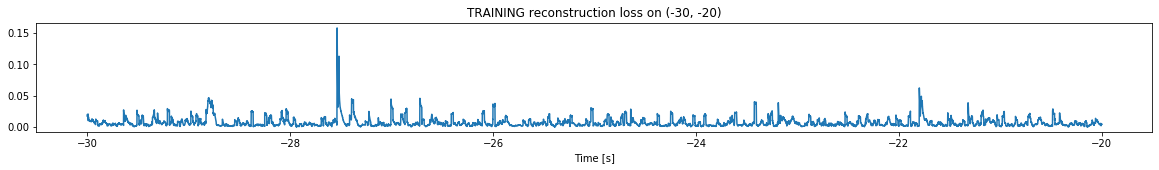

Finished training, median of the log(loss) is:  -2.2552902550849288
Triggering for section:  (-20, -10)
Using this median for triggering: -2.247555854777251


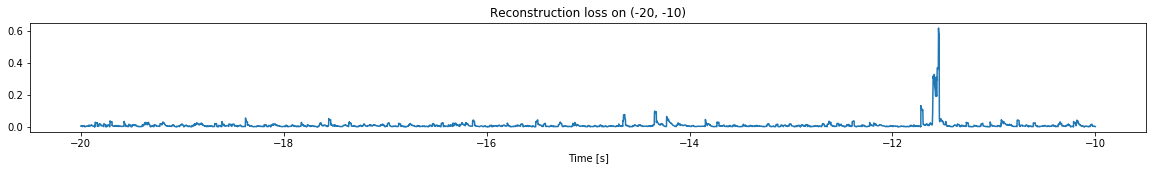

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


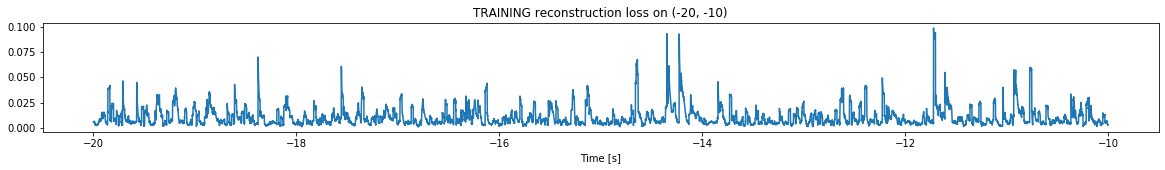

Finished training, median of the log(loss) is:  -2.1154841020954755
Triggering for section:  (-10, 0)
Using this median for triggering: -2.2552902550849288


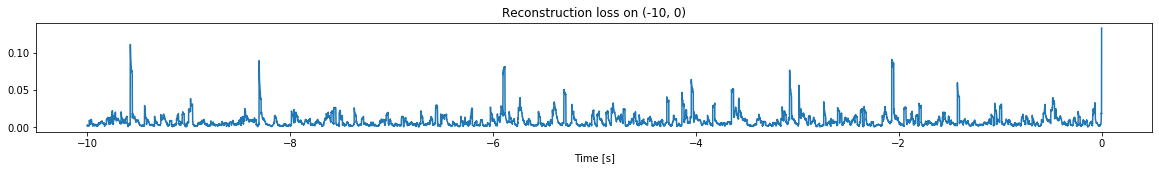

<--------
Finished simulation, all the triggered times are:  [-168.82687, -166.4916, -153.28778, -148.00539, -146.60258, -145.40349, -144.36908, -143.63148, -141.99028, -141.48988, -140.85748, -139.86438, -138.91528, -137.7788, -136.62788, -136.12749, -135.50468, -134.94289, -133.86868, -132.38109, -131.3039, -130.76549, -60.04899]


In [15]:
simulation("./data/Ramp20/", 10, (-200,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (1997500, 13)
Flushing input history
Number of sections: 20
Entering sections:  (-200, -190)
-------->
Entering sections:  (-190, -180)
-------->
Training for section:  (None, -190)


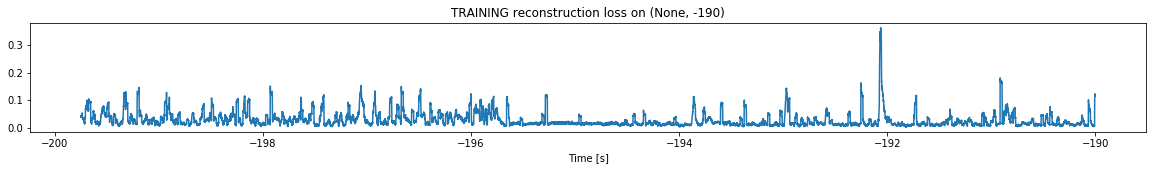

Finished training, median of the log(loss) is:  -1.7327863901432934
<--------
Entering sections:  (-180, -170)
-------->
Training for section:  (-190, -180)


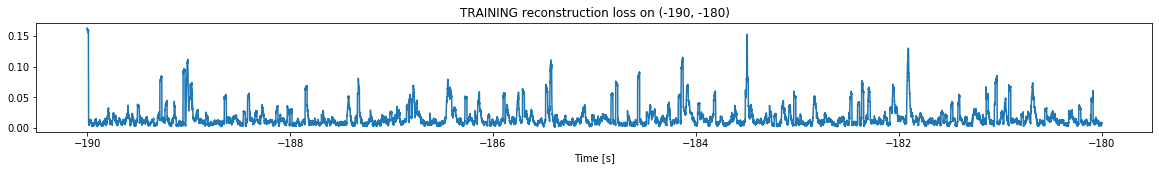

Finished training, median of the log(loss) is:  -1.938008155612743
Triggering for section:  (-180, -170)
Using this median for triggering: -1.7327863901432934


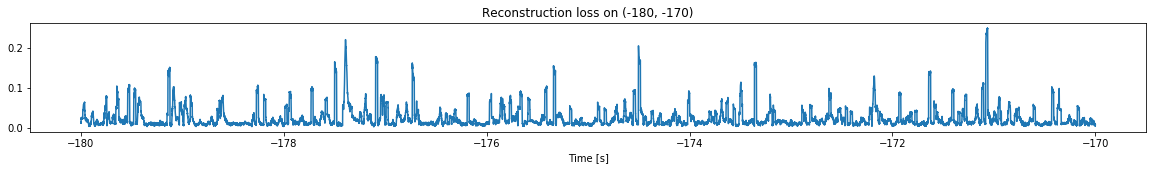

<--------
Entering sections:  (-170, -160)
-------->
Training for section:  (-180, -170)


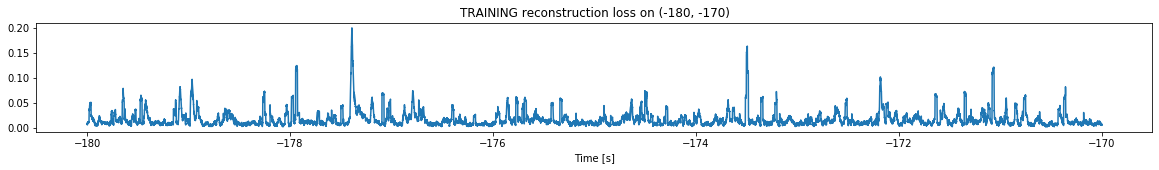

Finished training, median of the log(loss) is:  -1.9224755236712678
Triggering for section:  (-170, -160)
Using this median for triggering: -1.938008155612743


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: overflow encountered in power


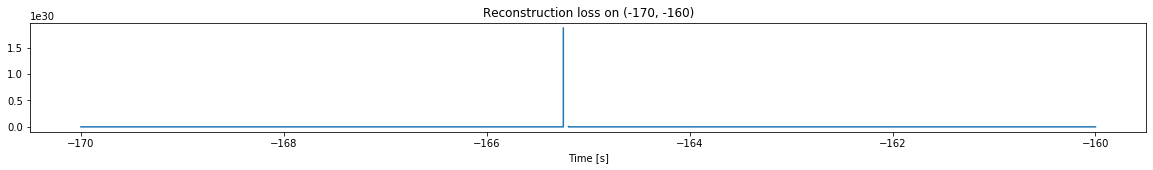

/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in greater


Other trigger time:  [-165.25148]
Their log loss values are:  [5.42653834]


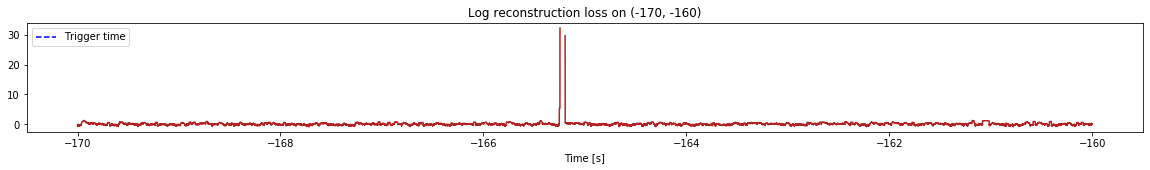

Triggered at:  [-165.25148]
<--------
Entering sections:  (-160, -150)
-------->
Training for section:  (-170, -160)


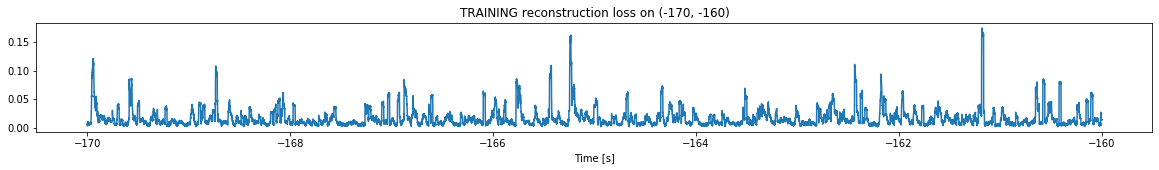

Finished training, median of the log(loss) is:  -1.92458895698424
Triggering for section:  (-160, -150)
Using this median for triggering: -1.9224755236712678


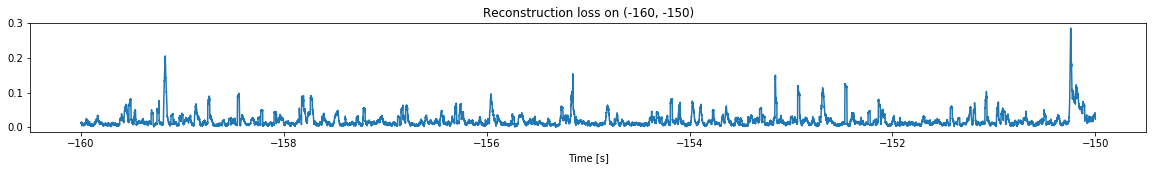

<--------
Entering sections:  (-150, -140)
-------->
Training for section:  (-160, -150)


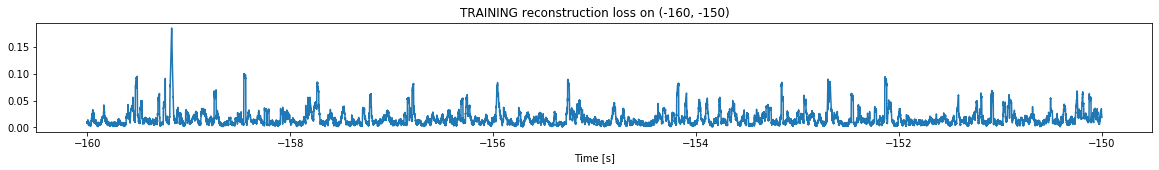

Finished training, median of the log(loss) is:  -1.9065300780838004
Triggering for section:  (-150, -140)
Using this median for triggering: -1.92458895698424


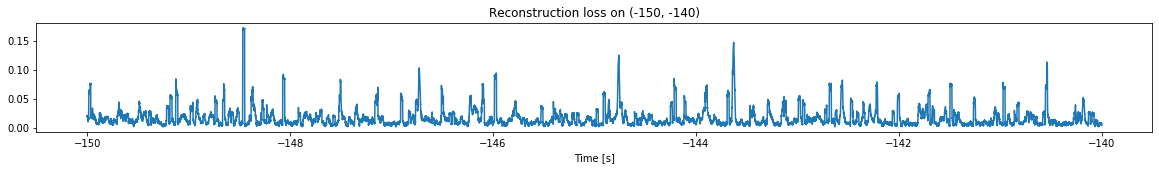

<--------
Entering sections:  (-140, -130)
-------->
Training for section:  (-150, -140)


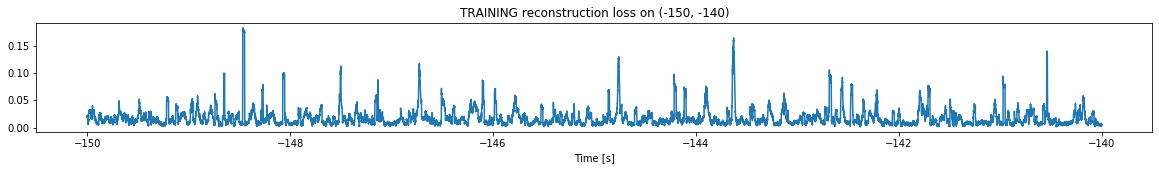

Finished training, median of the log(loss) is:  -1.8801124505424138
Triggering for section:  (-140, -130)
Using this median for triggering: -1.9065300780838004


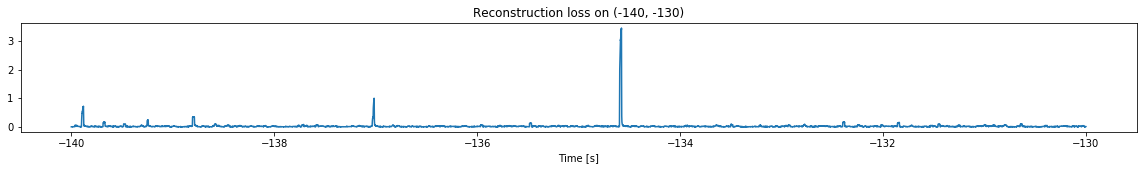

<--------
Entering sections:  (-130, -120)
-------->
Training for section:  (-140, -130)


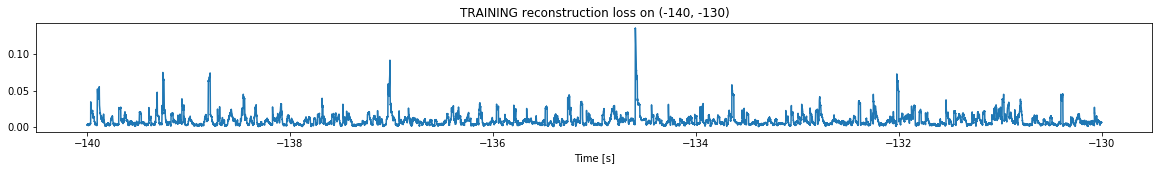

Finished training, median of the log(loss) is:  -2.1438819569419776
Triggering for section:  (-130, -120)
Using this median for triggering: -1.8801124505424138


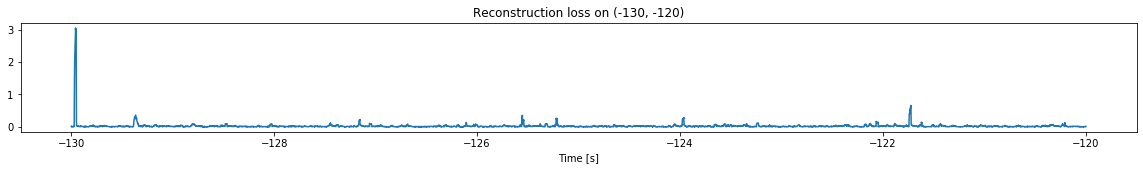

<--------
Entering sections:  (-120, -110)
-------->
Training for section:  (-130, -120)


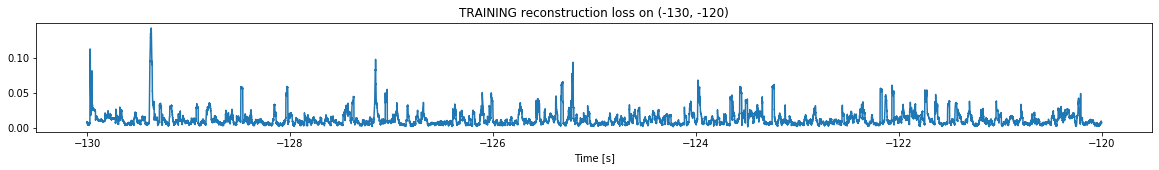

Finished training, median of the log(loss) is:  -2.0380640992210486
Triggering for section:  (-120, -110)
Using this median for triggering: -2.1438819569419776


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: overflow encountered in power


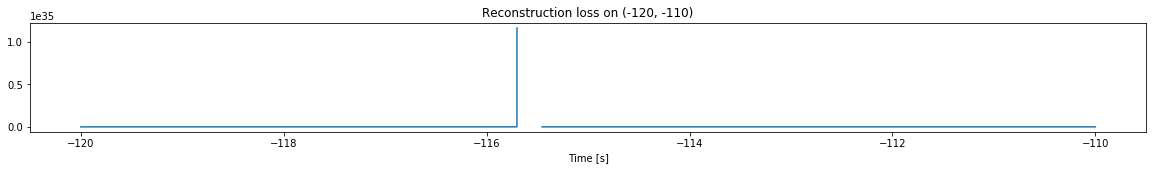

/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in greater


Other trigger time:  [-111.25209]
Their log loss values are:  [10.90616121]


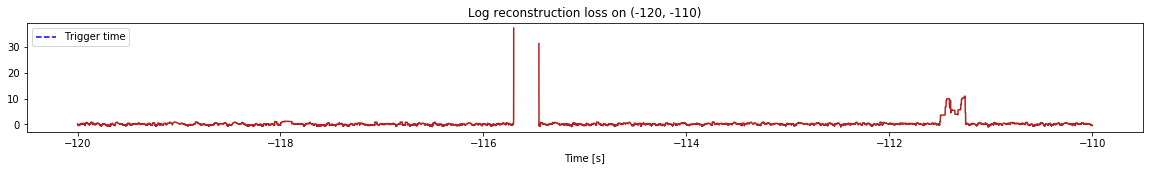

Triggered at:  [-111.25209]
<--------
Entering sections:  (-110, -100)
-------->
Training for section:  (-120, -110)


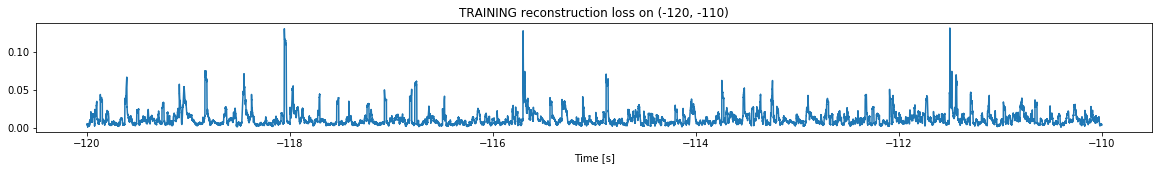

Finished training, median of the log(loss) is:  -2.0356778181008677
Triggering for section:  (-110, -100)
Using this median for triggering: -2.0380640992210486


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: overflow encountered in power


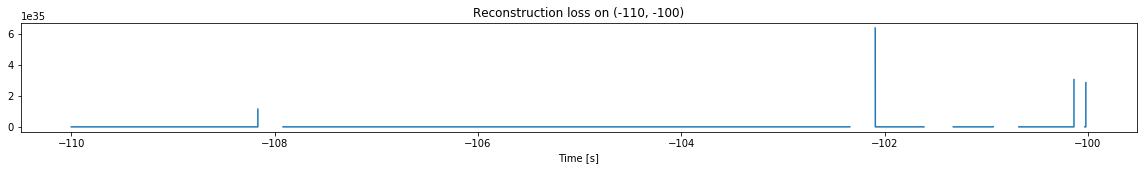

/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in greater


Other trigger time:  [-101.63969 -100.14939]
Their log loss values are:  [34.15763468 17.16222628]


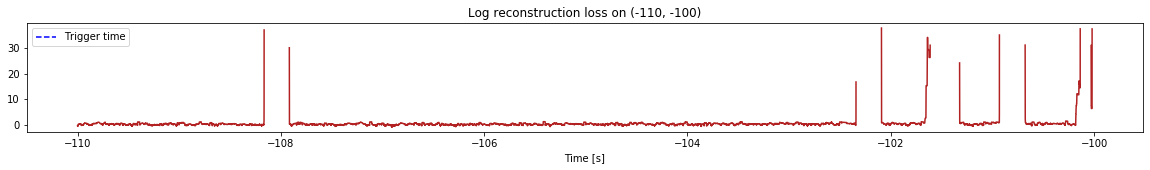

Triggered at:  [-101.63969, -100.14939]
<--------
Entering sections:  (-100, -90)
-------->
Training for section:  (-110, -100)


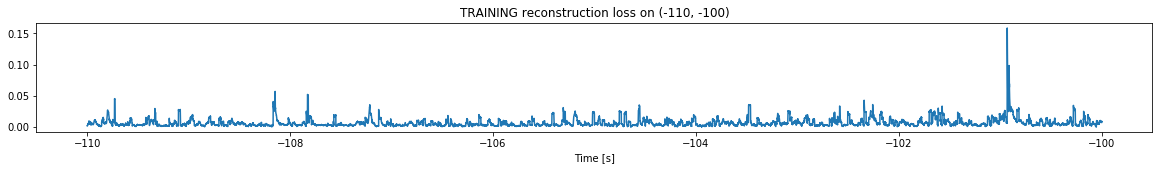

Finished training, median of the log(loss) is:  -2.2700034981555803
Triggering for section:  (-100, -90)
Using this median for triggering: -2.0356778181008677


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: overflow encountered in power


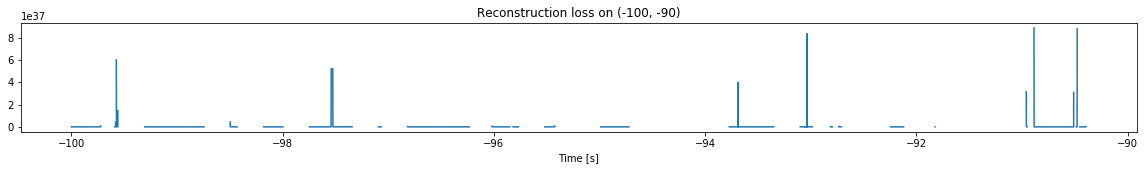

/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in greater


Other trigger time:  [-99.00759 -97.53209 -96.50899 -95.80619 -93.68769 -93.03319 -90.88379]
Their log loss values are:  [23.4937633  39.75165472 18.49466465 12.08798939 39.63610207 39.95729554
 32.76226433]


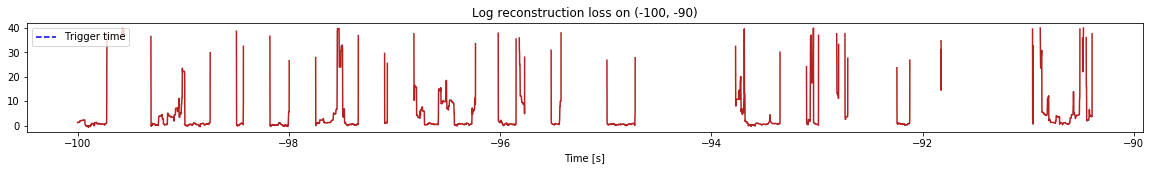

Triggered at:  [-99.00759, -97.53209, -96.50899, -95.80619, -93.68769, -93.03319, -90.88379]
<--------
Entering sections:  (-90, -80)
-------->
Training for section:  (-100, -90)


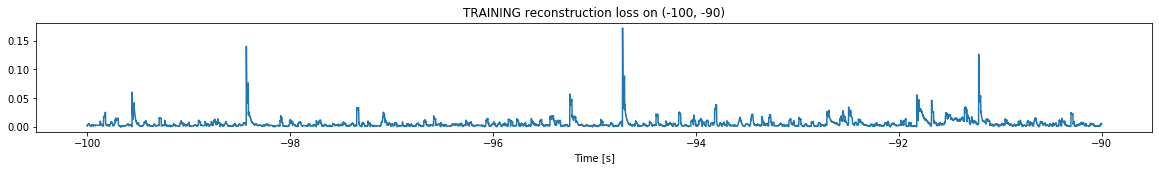

Finished training, median of the log(loss) is:  -2.3787394482218174
Triggering for section:  (-90, -80)
Using this median for triggering: -2.2700034981555803


/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:247: RuntimeWarning: overflow encountered in power


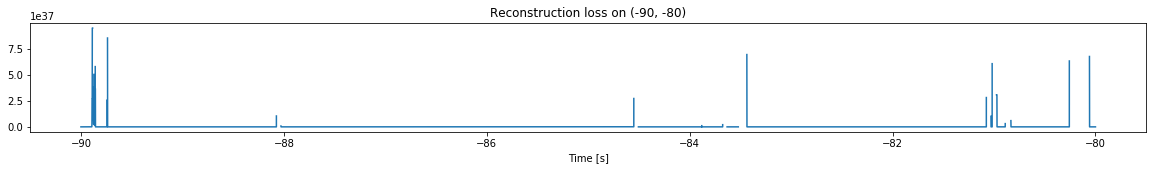

/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:270: RuntimeWarning: invalid value encountered in greater


Other trigger time:  [-89.87919  -87.86519  -86.797485 -83.56639  -80.924286 -80.024086]
Their log loss values are:  [39.57462446 13.6146921   5.09268657 15.6054068  29.86507753 36.39395634]


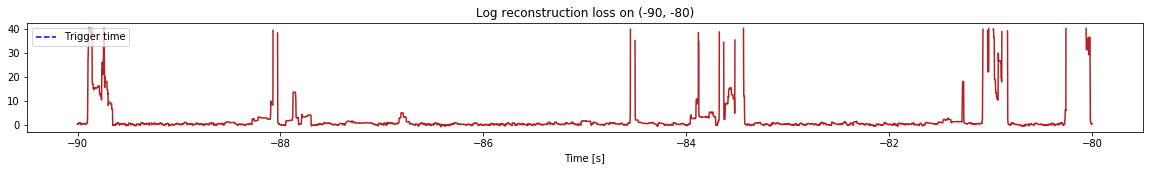

Triggered at:  [-89.87919, -87.86519, -86.797485, -83.56639, -80.924286, -80.024086]
<--------
Entering sections:  (-80, -70)
-------->
Training for section:  (-90, -80)


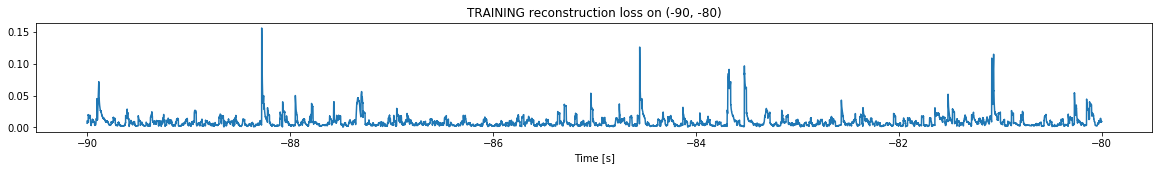

Finished training, median of the log(loss) is:  -2.208115423737917
Triggering for section:  (-80, -70)
Using this median for triggering: -2.3787394482218174


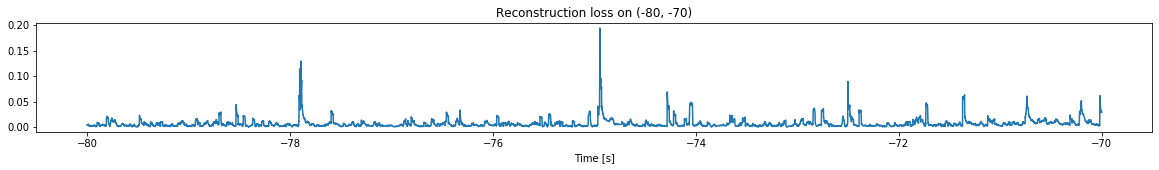

<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


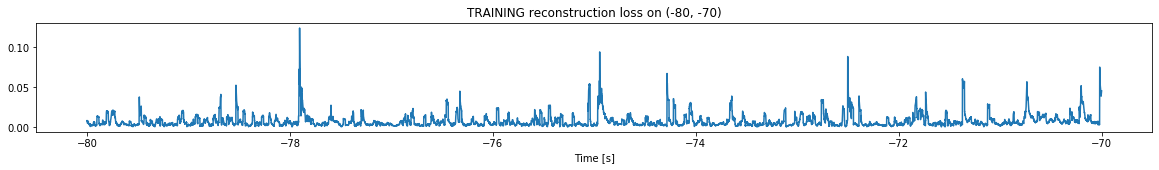

Finished training, median of the log(loss) is:  -2.2639150918450626
Triggering for section:  (-70, -60)
Using this median for triggering: -2.208115423737917


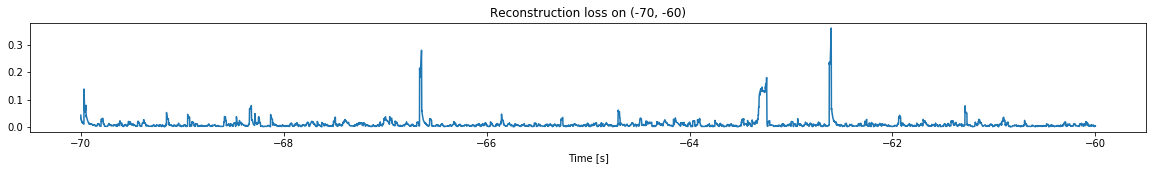

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


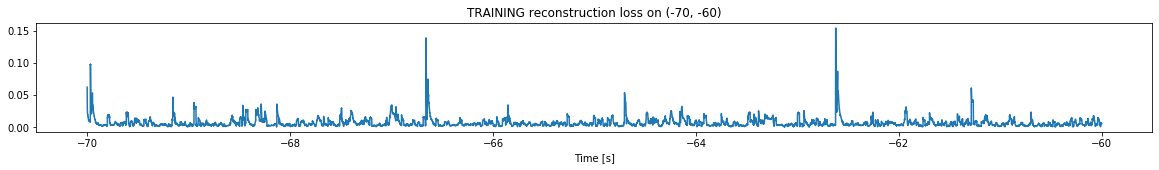

Finished training, median of the log(loss) is:  -2.278625564481314
Triggering for section:  (-60, -50)
Using this median for triggering: -2.2639150918450626


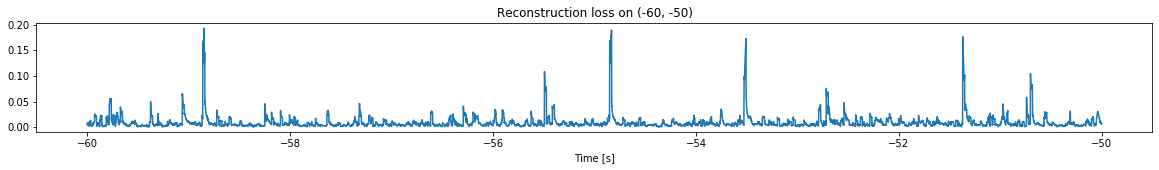

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


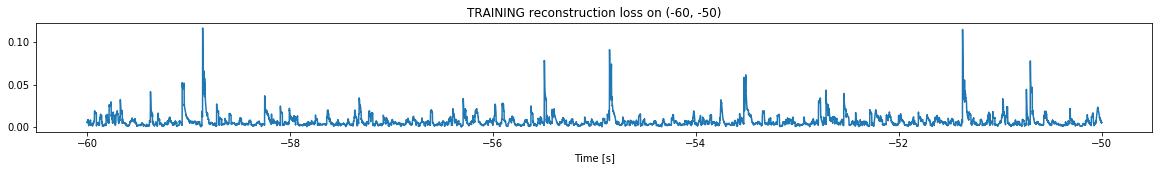

Finished training, median of the log(loss) is:  -2.2885207416030564
Triggering for section:  (-50, -40)
Using this median for triggering: -2.278625564481314


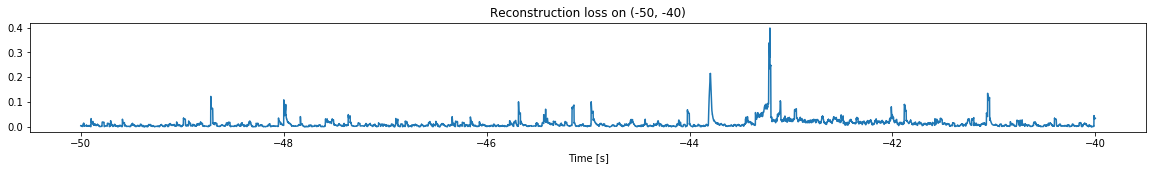

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


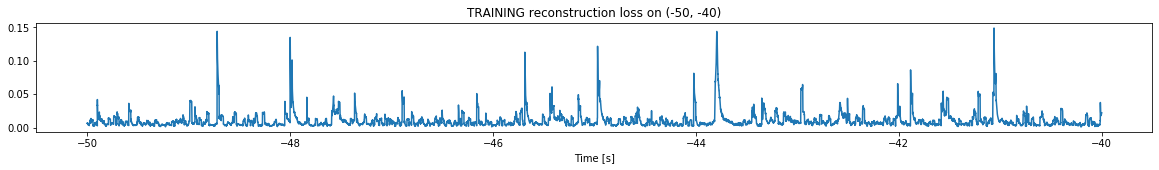

Finished training, median of the log(loss) is:  -2.137588412618059
Triggering for section:  (-40, -30)
Using this median for triggering: -2.2885207416030564


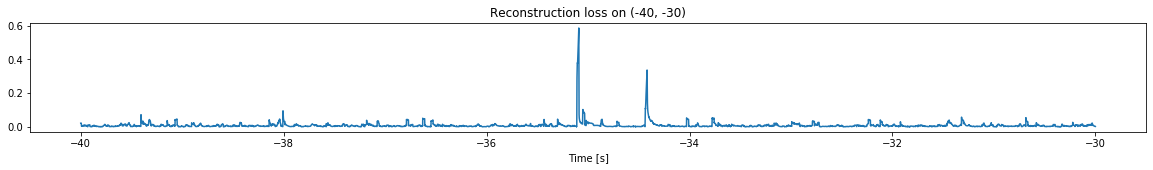

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


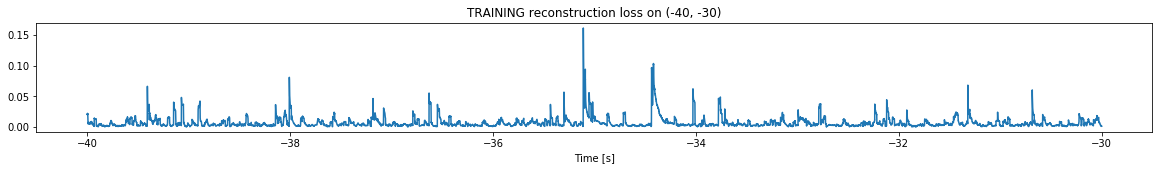

Finished training, median of the log(loss) is:  -2.3206187011649004
Triggering for section:  (-30, -20)
Using this median for triggering: -2.137588412618059


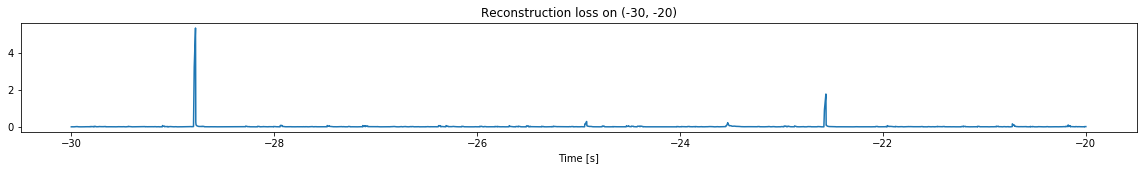

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


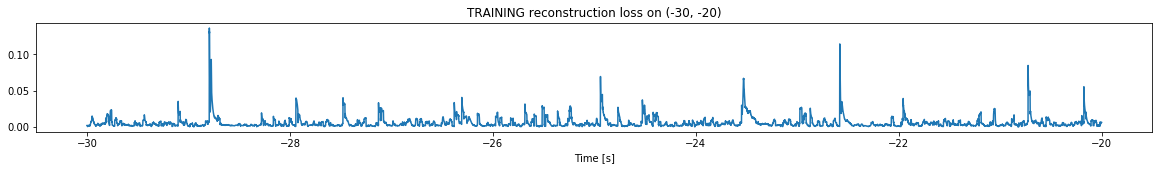

Finished training, median of the log(loss) is:  -2.412164195999461
Triggering for section:  (-20, -10)
Using this median for triggering: -2.3206187011649004


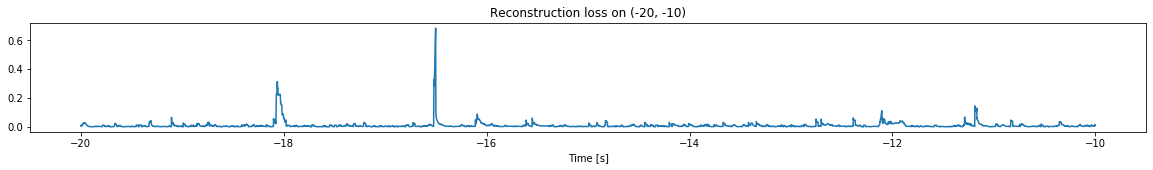

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


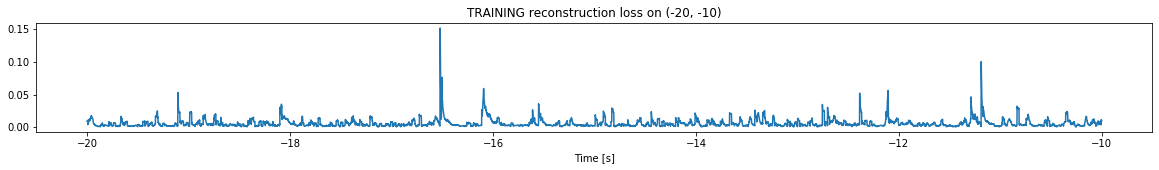

Finished training, median of the log(loss) is:  -2.372359369038703
Triggering for section:  (-10, 0)
Using this median for triggering: -2.412164195999461


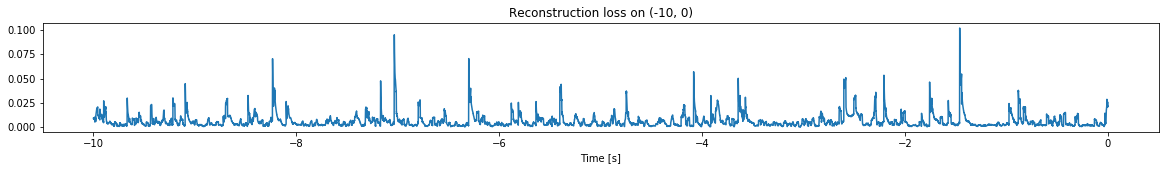

<--------
Finished simulation, all the triggered times are:  [-165.25148, -111.25209, -101.63969, -100.14939, -99.00759, -97.53209, -96.50899, -95.80619, -93.68769, -93.03319, -90.88379, -89.87919, -87.86519, -86.797485, -83.56639, -80.924286, -80.024086]


In [14]:
simulation("./data/Ramp19/", 10, (-200,0))

In [ ]:
## Threshold 3.3; constant 1.1; power of 3

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (599800, 13)
Flushing input history
Number of sections: 6
Entering sections:  (-60, -50)
-------->
Entering sections:  (-50, -40)
-------->
Training for section:  (None, -50)


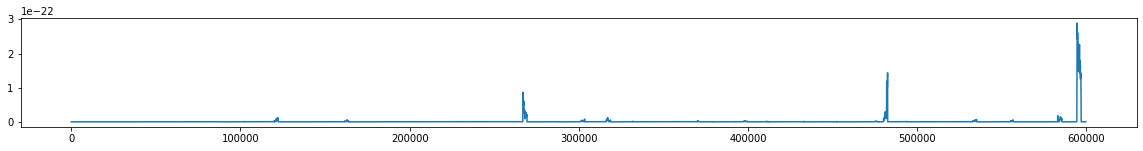

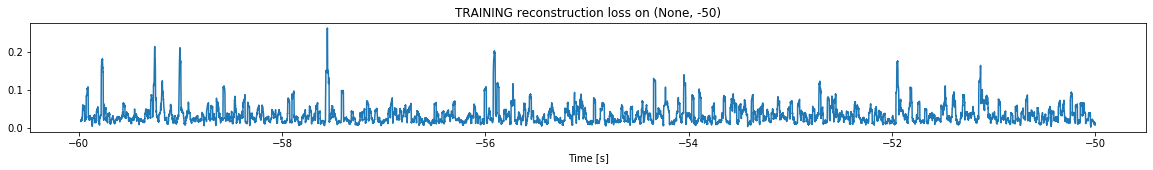

Finished training, median of the log(loss) is:  -1.5298287983818515
<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


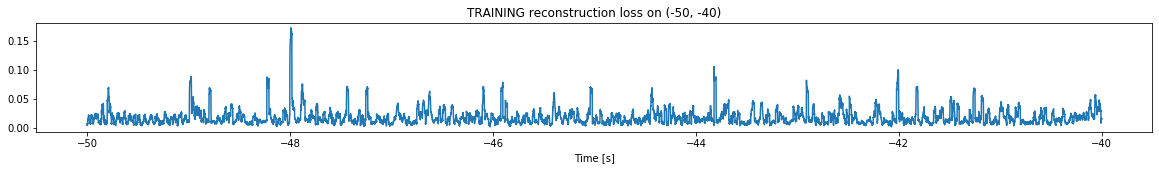

Finished training, median of the log(loss) is:  -1.8226168131778808
Triggering for section:  (-40, -30)
Using this median for triggering: -1.5298287983818515


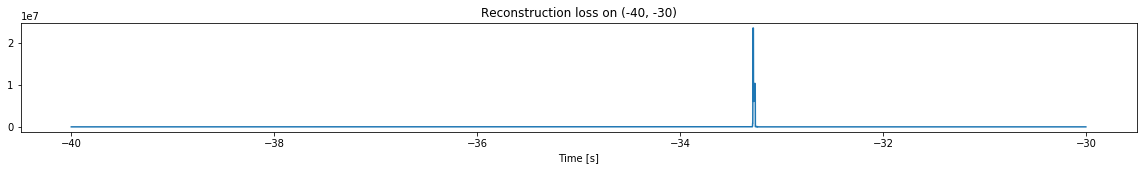

Other trigger time:  [-33.2771]
Their log loss values are:  [8.90151913]


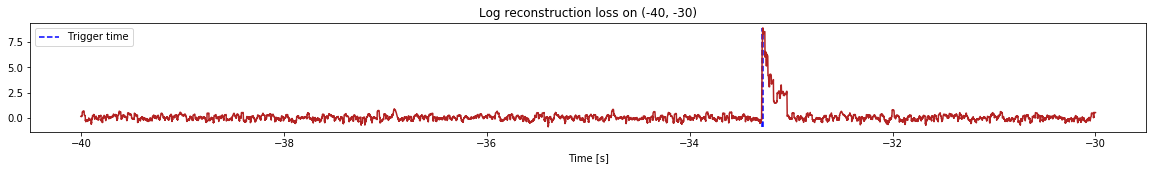

Triggered at:  [-33.2771]
<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


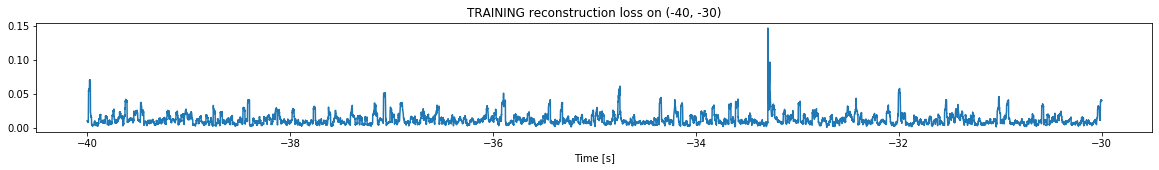

Finished training, median of the log(loss) is:  -2.0025986900813697
Triggering for section:  (-30, -20)
Using this median for triggering: -1.8226168131778808


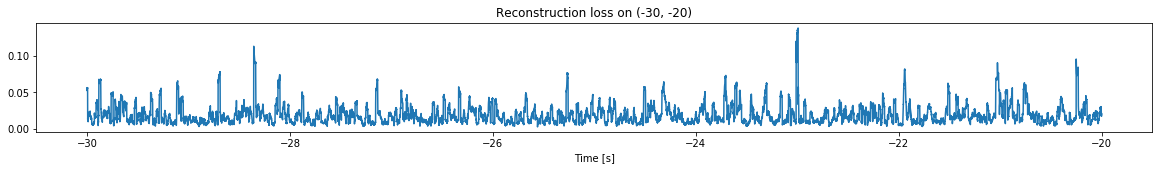

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


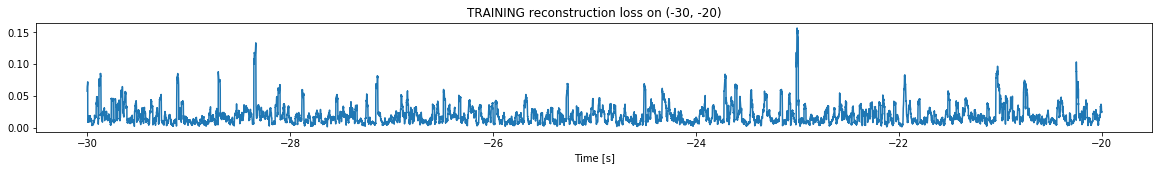

Finished training, median of the log(loss) is:  -1.7885885503898298
Triggering for section:  (-20, -10)
Using this median for triggering: -2.0025986900813697


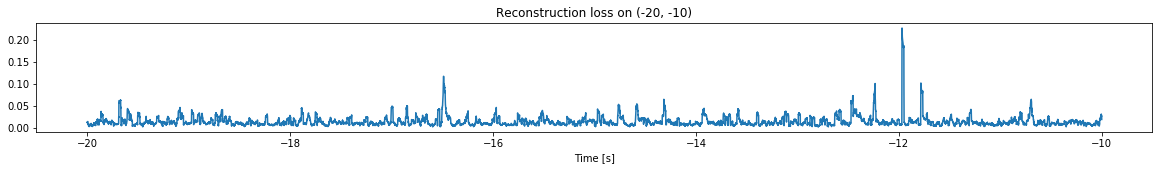

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


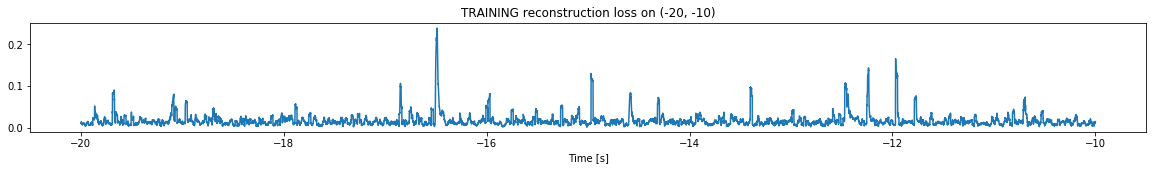

Finished training, median of the log(loss) is:  -1.859528560643259
Triggering for section:  (-10, 0)
Using this median for triggering: -1.7885885503898298


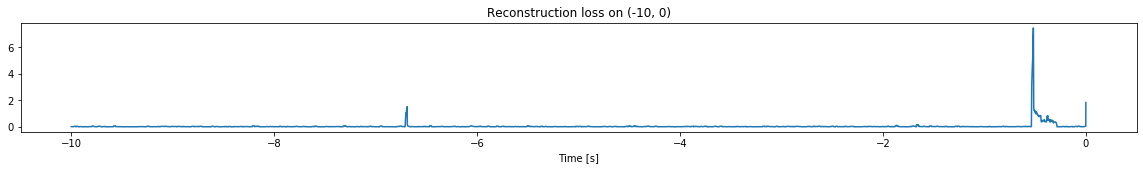

<--------
Finished simulation, all the triggered times are:  [-33.2771]


In [47]:
simulation("./data/Ramp28/", 10, (-60,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (599800, 13)
Flushing input history
Number of sections: 12
Entering sections:  (-60, -55)
-------->
Entering sections:  (-55, -50)
-------->
Training for section:  (None, -55)


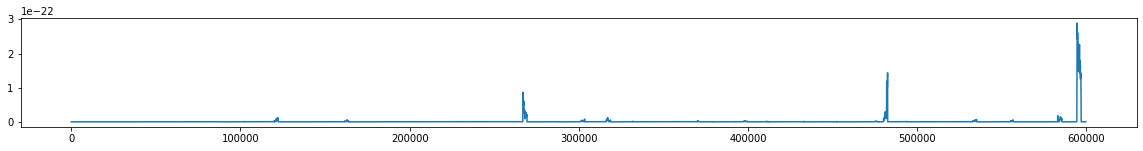

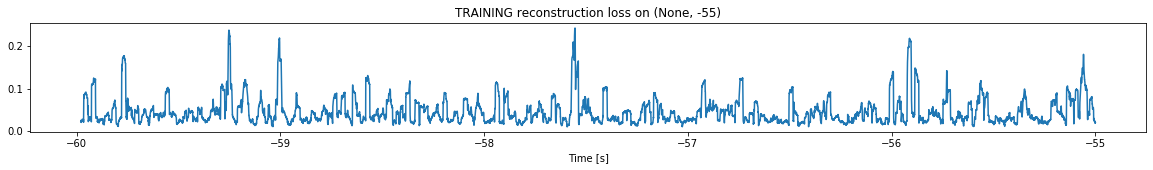

Finished training, median of the log(loss) is:  -1.4327970330326854
<--------
Entering sections:  (-50, -45)
-------->
Training for section:  (-55, -50)


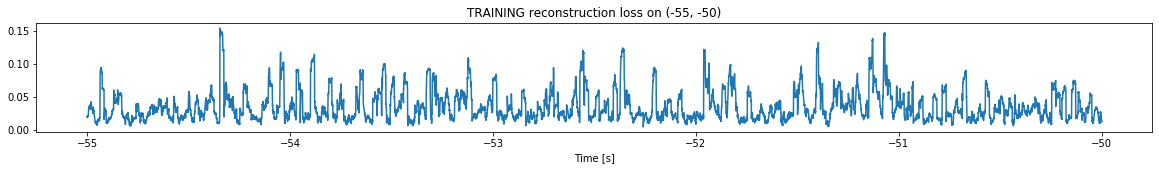

Finished training, median of the log(loss) is:  -1.5344604164631683
Triggering for section:  (-50, -45)
Using this median for triggering: -1.4327970330326854


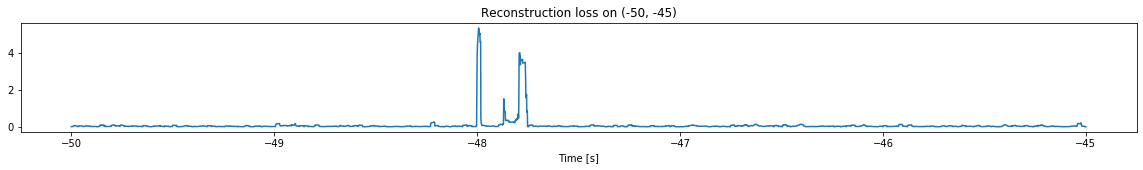

<--------
Entering sections:  (-45, -40)
-------->
Training for section:  (-50, -45)


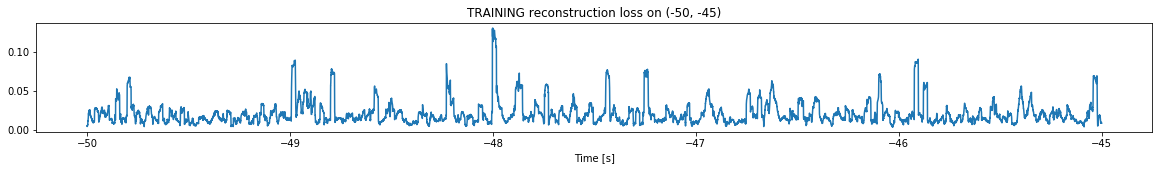

Finished training, median of the log(loss) is:  -1.7751100390795238
Triggering for section:  (-45, -40)
Using this median for triggering: -1.5344604164631683


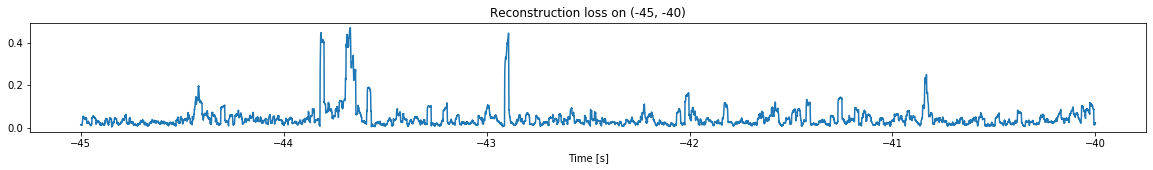

<--------
Entering sections:  (-40, -35)
-------->
Training for section:  (-45, -40)


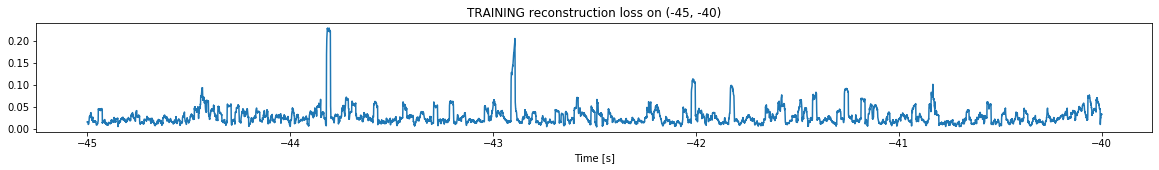

Finished training, median of the log(loss) is:  -1.6524831097065855
Triggering for section:  (-40, -35)
Using this median for triggering: -1.7751100390795238


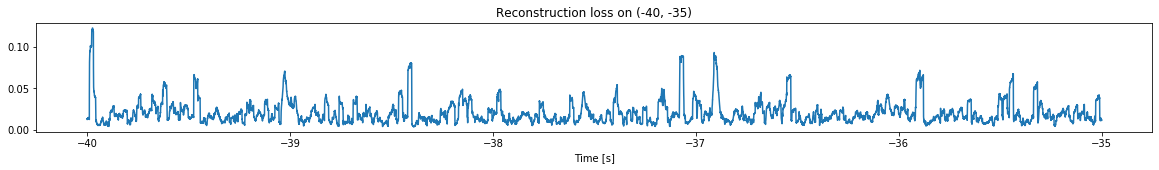

<--------
Entering sections:  (-35, -30)
-------->
Training for section:  (-40, -35)


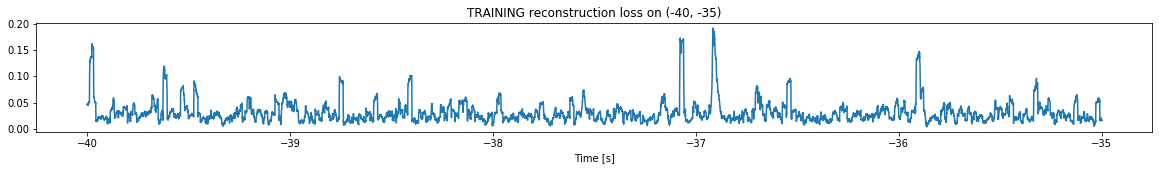

Finished training, median of the log(loss) is:  -1.5782215493701015
Triggering for section:  (-35, -30)
Using this median for triggering: -1.6524831097065855


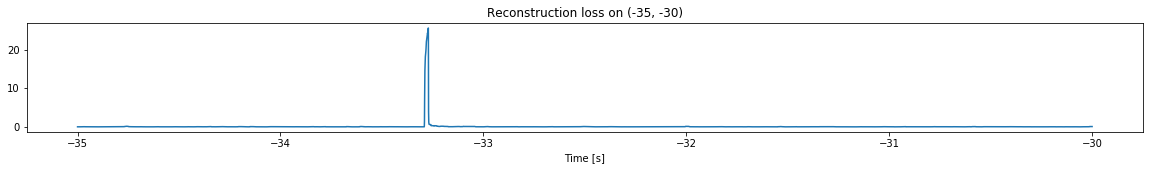

<--------
Entering sections:  (-30, -25)
-------->
Training for section:  (-35, -30)


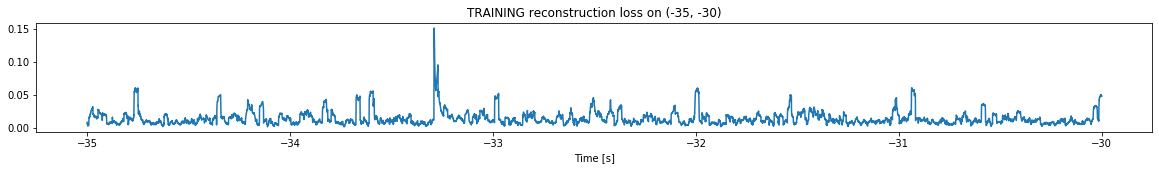

Finished training, median of the log(loss) is:  -1.9136093494462352
Triggering for section:  (-30, -25)
Using this median for triggering: -1.5782215493701015


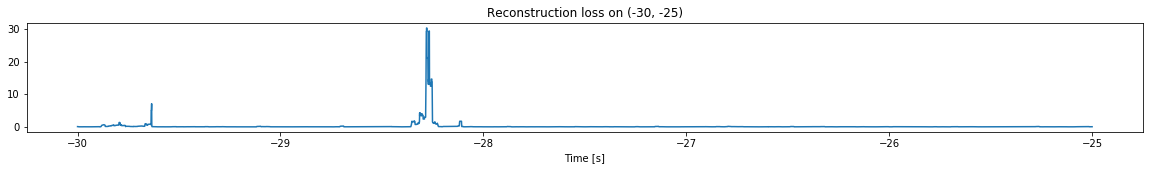

<--------
Entering sections:  (-25, -20)
-------->
Training for section:  (-30, -25)


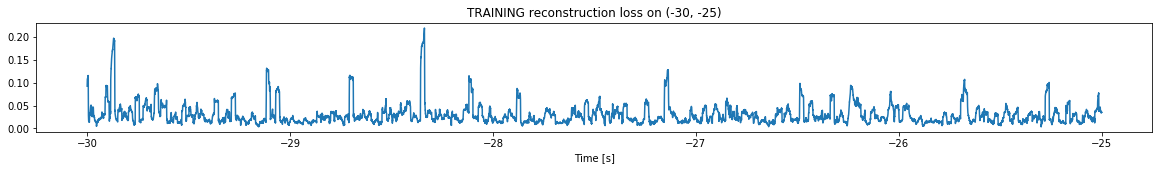

Finished training, median of the log(loss) is:  -1.6120553347689173
Triggering for section:  (-25, -20)
Using this median for triggering: -1.9136093494462352


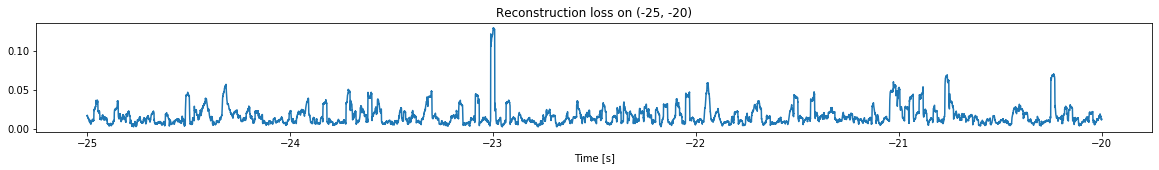

<--------
Entering sections:  (-20, -15)
-------->
Training for section:  (-25, -20)


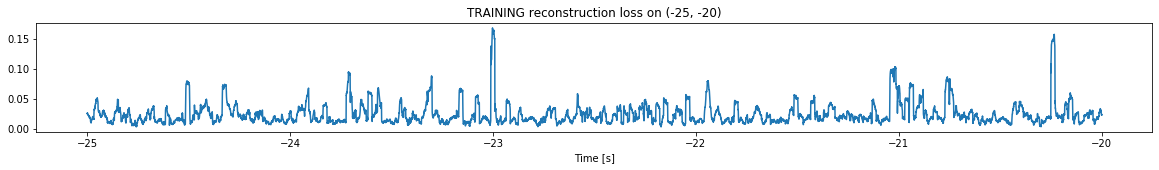

Finished training, median of the log(loss) is:  -1.706373719458953
Triggering for section:  (-20, -15)
Using this median for triggering: -1.6120553347689173


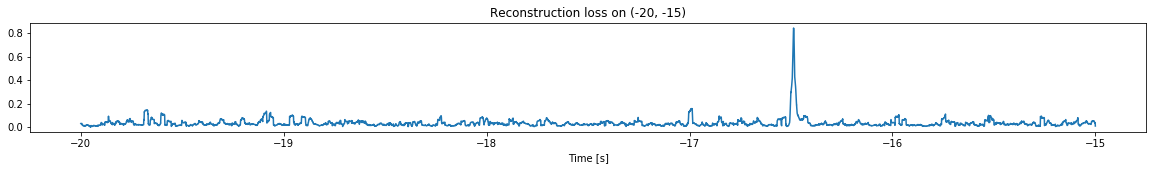

<--------
Entering sections:  (-15, -10)
-------->
Training for section:  (-20, -15)


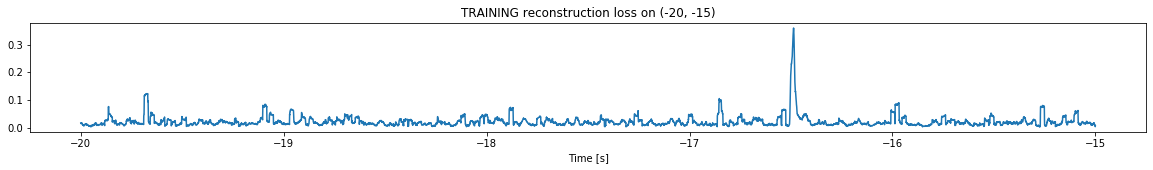

Finished training, median of the log(loss) is:  -1.7474871867134953
Triggering for section:  (-15, -10)
Using this median for triggering: -1.706373719458953


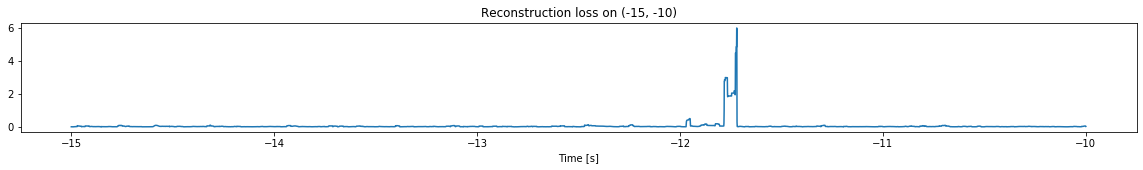

<--------
Entering sections:  (-10, -5)
-------->
Training for section:  (-15, -10)


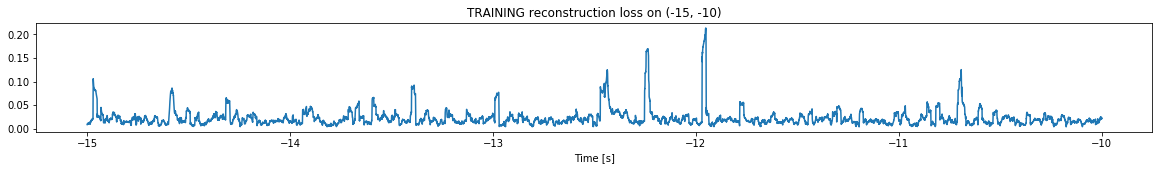

Finished training, median of the log(loss) is:  -1.7405940760632297
Triggering for section:  (-10, -5)
Using this median for triggering: -1.7474871867134953


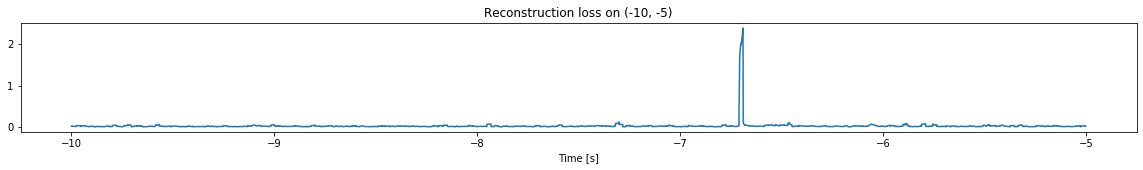

<--------
Entering sections:  (-5, 0)
-------->
Training for section:  (-10, -5)


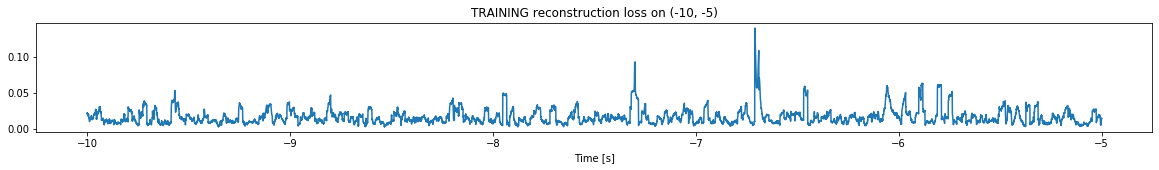

Finished training, median of the log(loss) is:  -1.8430885880228294
Triggering for section:  (-5, 0)
Using this median for triggering: -1.7405940760632297


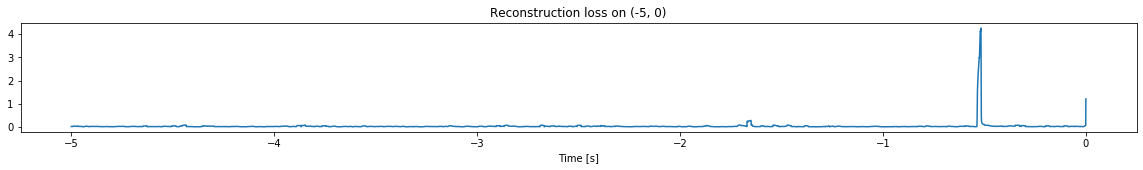

<--------
Finished simulation, all the triggered times are:  []


In [48]:
simulation("./data/Ramp28/", 5, (-60,0))

In [ ]:
simulation("./data/Ramp29/", 10, (-100,0))